# **ECON 585 Final Project**
### By Peterson, Seth and Vorkink, Eric

## **SECTION 0:** Setting Up Development Environment

In [125]:
# The FamaData class was created by Seth Peterson for purpose of the 588 Project
from fama_data.FamaData import FamaData

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import QuantReg
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')

## **SECTION 1:** Importing and Gathering Data

#### Section 1a: Testing Portfolios

In [126]:
# Our first testing portfolios
# Equal-weighted momentum portfolios

url = 'http://diether.org/prephd/10-port_mom_ew.csv'
port = pd.read_csv(url,parse_dates=['caldt'])
port = port.query('caldt >= "1970-01-30" and caldt <= "2023-02-28"')
port['spread'] = port['p4'] - port['p0']

In [127]:
# Our second testing portfolio
# The monthly returns on the S&P 500 index
sp_df = pd.read_csv('data/S&P 500 Historical Data.csv',parse_dates=['Date'])
sp_df['caldt'] = sp_df['Date'] - pd.offsets.Day(1)
sp_df['ret'] = sp_df['Change %'].str.replace('%','').astype(float)
sp_df = sp_df[['caldt','ret']]
sp_df.head(3)

,caldt,ret
0,2023-03-31,0.69
1,2023-02-28,3.51
2,2023-01-31,-2.61


#### Section 1b: Ken French Data Library Zero Cost Portfolios

In [128]:
# Initialize FamaData object
fd = FamaData('data/', begin_date = '1970-01-31', end_date = '2022-09-30')

In [129]:
# Compute all non-standard factors from Fama and French data library using FamaData object

share_issue_delta = fd.get_net_share_issue_data()['Hi 10'] - fd.get_net_share_issue_data()['Lo 10']

shortterm_rev_delta = fd.get_shortterm_reversal_data()['Hi PRIOR'] - fd.get_shortterm_reversal_data()['Lo PRIOR']
longterm_rev_delta = fd.get_longterm_reversal_data()['Hi PRIOR'] - fd.get_longterm_reversal_data()['Lo PRIOR']

# Two industry factors that we build by hand
service_minus_goods = 2 * fd.get_49_industry_data()['PerSv'] + 2 * fd.get_49_industry_data()['BusSv'] \
                    + fd.get_49_industry_data()['Softw'] + fd.get_49_industry_data()['Insur'] \
                    + fd.get_49_industry_data()['Fins'] + fd.get_49_industry_data()['Banks'] \
                    - fd.get_49_industry_data()['Hshld'] - fd.get_49_industry_data()['BldMt'] \
                    - fd.get_49_industry_data()['ElcEq'] - fd.get_49_industry_data()['Aero'] \
                    - fd.get_49_industry_data()['Food '] - fd.get_49_industry_data()['Oil'] \
                    - 2 * fd.get_49_industry_data()['Whlsl']

needs_minus_wants = fd.get_49_industry_data()['Food '] + fd.get_49_industry_data()['Util'] \
                    + fd.get_49_industry_data()['Hlth '] + fd.get_49_industry_data()['MedEq'] \
                    + fd.get_49_industry_data()['Drugs'] + fd.get_49_industry_data()['Insur'] \
                    - fd.get_49_industry_data()['Guns'] - fd.get_49_industry_data()['Softw'] \
                    - fd.get_49_industry_data()['Autos'] - fd.get_49_industry_data()['Whlsl'] \
                    - 2*fd.get_49_industry_data()['Hshld']


accrual_delta = fd.get_accrual_data()['Hi 10'] - fd.get_accrual_data()['Lo 10']
cashflow_price_delta = fd.get_cashflow_price_data()['Hi 10'] - fd.get_cashflow_price_data()['Lo 10']
market_beta_delta = fd.get_market_beta_data()['Hi 10'] - fd.get_market_beta_data()['Lo 10']
dividend_yield_delta = fd.get_dividend_yield_data()['Hi 10'] - fd.get_dividend_yield_data()['Lo 10']
earnings_price_delta = fd.get_earnings_price_data()['Hi 10'] - fd.get_earnings_price_data()['Lo 10']
variance_delta = fd.get_variance_data()['Hi 10'] - fd.get_variance_data()['Lo 10']


share_issue_delta.name = 'share_issue_delta'
shortterm_rev_delta.name = 'shortterm_rev_delta'
longterm_rev_delta.name = 'longterm_rev_delta'
service_minus_goods.name = 'service_minus_goods'
needs_minus_wants.name = 'needs_minus_wants'
accrual_delta.name = 'accrual_delta'
cashflow_price_delta.name = 'cashflow_price_delta'
market_beta_delta.name = 'market_beta_delta'
dividend_yield_delta.name = 'dividend_yield_delta'
earnings_price_delta.name = 'earnings_price_delta'
variance_delta.name = 'variance_delta'

In [130]:
# Gather the standard Fama-French factors from the FamaData object

# NOTE TO READER: The FamaData object has a method called get_excess_return_data() that returns the excess returns
# This function is dependent on the python package `getFamaFrenchFactors`
# If you do not have this package installed, you can install it using the command `pip install getFamaFrenchFactors`

excess_returns = fd.get_excess_return_data()['exmt']

SMB_proxy = fd.get_size_data()['Hi 10'] - fd.get_size_data()['Lo 10']
HML_proxy = fd.get_book_to_market_data()['Hi 10'] - fd.get_book_to_market_data()['Lo 10']
RMW_proxy = fd.get_operating_profitability_data()['Hi 10'] - fd.get_operating_profitability_data()['Lo 10']
CMA_proxy = fd.get_investment_data()['Hi 10'] - fd.get_investment_data()['Lo 10']
MOM_proxy = fd.get_momentum_data()['Hi PRIOR'] - fd.get_momentum_data()['Lo PRIOR']

SMB_proxy.name = 'SMB'
HML_proxy.name = 'HML'
RMW_proxy.name = 'RMW'
CMA_proxy.name = 'CMA'
MOM_proxy.name = 'MOM'

In [131]:
# Reset the indices of all the dataframes to be the same; this is necessary for concatenation
# Also, generate two dataframes: one with the alternative factors and one with the standard factors

for x in [share_issue_delta, shortterm_rev_delta, longterm_rev_delta, 
                service_minus_goods, needs_minus_wants, accrual_delta, 
                cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                earnings_price_delta, variance_delta]:
    x.reset_index(drop=True, inplace=True)

for x in [excess_returns, SMB_proxy, HML_proxy, RMW_proxy, CMA_proxy, MOM_proxy]:
    x.reset_index(drop=True, inplace=True)

# Create a dataframe with all the data
alt_factor_df = pd.concat([port['caldt'].reset_index(drop = 'True'), excess_returns, share_issue_delta, 
                           shortterm_rev_delta, longterm_rev_delta, service_minus_goods, needs_minus_wants, 
                           accrual_delta, cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                           earnings_price_delta], axis=1)

standard_factor_df = pd.concat([port['caldt'].reset_index(drop = 'True'), excess_returns, SMB_proxy, 
                                HML_proxy, RMW_proxy, CMA_proxy, MOM_proxy], axis=1)

In [132]:
alt_factor_df.head(3)

,caldt,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,service_minus_goods,needs_minus_wants,accrual_delta,cashflow_price_delta,market_beta_delta,dividend_yield_delta,earnings_price_delta
0,1970-01-30,-8.10,-4.74,0.56,-6.45,-57.02,31.31,3.33,0.66,-3.92,4.59,2.81
1,1970-02-27,5.13,-3.51,-3.45,-4.25,16.89,-17.58,-2.39,2.53,-1.54,4.94,4.33
2,1970-03-31,-1.06,-6.73,-0.73,-6.70,-26.91,1.89,0.42,6.07,-6.80,6.42,5.20


In [133]:
standard_factor_df.head(3)

,caldt,exmt,SMB,HML,RMW,CMA,MOM
0,1970-01-30,-8.10,-6.17,5.86,-2.98,-5.34,-0.43
1,1970-02-27,5.13,2.91,4.92,-3.89,-2.41,-0.55
2,1970-03-31,-1.06,4.19,4.16,-0.43,-4.61,0.87


#### Section 1c: 36-Factor Interaction Portfolios (TO BE LASSO'D LATER)

In [134]:
# Pull out the 10 industry factors from the FamaData object
# NOTE TO READER: There are 9 factors (10 industries minus 1 industry that is the other category)
#                 We compute 9^2 = 81 pairwise differences between the 9 factors
#                 Then, we ignore the 9 factors that are the same (e.g. the difference between the "HiTec" industry and the "HiTec" industry)
#                 Lastly, we divide by 2 to account for double-counting (e.g. the difference between the "HiTec" industry and the "Autos" industry 
#                                                             is the same as the difference between the "Autos" industry and the "HiTec" industry)
#                 This leaves us with 36 pairwise differences between the 9 factors (72 / 2 = 36)

factor_port = fd.get_10_industry_data()
cols = factor_port.columns[:-2] # Ignore caldt and Other

many_factor_df = pd.DataFrame(columns = ['caldt'])
many_factor_df['caldt'] = factor_port['caldt']

# Avoid double-counting factors
for i, col_i in enumerate(cols):
    for j, col_j in enumerate(cols):
        if i < j:
            many_factor_df[cols[i].strip() + 'Minus' + cols[j].strip()] = factor_port[cols[i]] - factor_port[cols[j]]

In [135]:
many_factor_df.head(3)

,caldt,NoDurMinusDurbl,NoDurMinusManuf,NoDurMinusEnrgy,NoDurMinusHiTec,NoDurMinusTelcm,NoDurMinusShops,NoDurMinusHlth,NoDurMinusUtils,DurblMinusManuf,...,HiTecMinusTelcm,HiTecMinusShops,HiTecMinusHlth,HiTecMinusUtils,TelcmMinusShops,TelcmMinusHlth,TelcmMinusUtils,ShopsMinusHlth,ShopsMinusUtils,HlthMinusUtils
0,1970-01-31,3.94,3.00,7.14,4.77,-1.74,1.63,2.81,-0.07,-0.94,...,-6.51,-3.14,-1.96,-4.84,3.37,4.55,1.67,1.18,-1.70,-2.88
1,1970-02-28,-1.14,-0.45,-0.66,1.77,-3.23,-0.47,-0.85,-3.64,0.69,...,-5.00,-2.24,-2.62,-5.41,2.76,2.38,-0.41,-0.38,-3.17,-2.79
2,1970-03-31,-5.85,-0.57,-0.43,1.72,-3.15,0.88,4.24,-3.77,5.28,...,-4.87,-0.84,2.52,-5.49,4.03,7.39,-0.62,3.36,-4.65,-8.01


#### Section 1d: Creating own value-weighted factor portfolios using CRSP-Compustat merged accounting data

In [136]:
# Create 6 value-weighted factor portfolios built from accounting data
# Data provided by CRSP-Computstat Merged Database

df = pd.read_csv('data/cst.csv').drop(['fyear', 'gvkey'], axis = 1)
df['caldt'] = pd.to_datetime(df['caldt'])
df = df.query('caldt >= "1970-01-31" and caldt <= "2023-02-28"')

"""
HAND-MADE ACCOUNTING RATIOS:
A portfolio of stocks with high interest, advertising, and research and development expenses relative to their assets
xint       interest expense
xad        advertising expense
xrd        research and development expense
at         total assets
invst      (xint + xad + xrd) / at

A portfolio of efficient firms in terms of their cost of goods sold, and their sales and administrative expenses relative to their assets
cogs       cost of goods sold
xsga       selling, general, and administrative expense
effc       (at - cogs - xsga) / at


STANDARD ACCOUNTING RATIOS:
Quick Ratio:
act        current assets - total
invt       inventories - total
lct        current liabilities - total
quick      (act - invt) / lct

Return on Equity:
revt       revenue - total
xint       interest expense
xad        advertising expense
xrd        research and development expense
xsga       selling, general, and administrative expense
seq        stockholders equity - total
roe        (revt - xint - xad - xrd - xsga) / seq

Fixed Asset Turnover:
act        current assets - total
at         total assets
fat        revt / (at - act)

Debt Ratio:
dltt         long-term debt
dlc          current liabilities
at           total assets
debt_ratio   (dltt + dlc) / at
"""

df['invst'] = (df['xint'] + df['xad'] + df['xrd']) / df['at']
df['effc'] = (df['at'] - df['cogs'] - df['xsga']) / df['at']
df['quick'] = (df['act'] - df['invt']) / df['lct']
df['roe'] = (df['revt'] - df['xint'] - df['xad'] - df['xrd'] - df['xsga']) / df['seq']
df['fat'] = df['revt'] / (df['at'] - df['act'])
df['debt_ratio'] = (df['dltt'] + df['dlc']) / df['at']

In [137]:
# Place accounting ratios into a dataframe and lag them by 1 month
factors = ['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio']
f_df = df[factors + ['permno', 'caldt']]

# We must avoid look-ahead bias.
f_df.sort_values(['permno', 'caldt'], inplace = True)
f_df['invst_lag'] = f_df.groupby('permno')['invst'].shift(1)
f_df['effc_lag'] = f_df.groupby('permno')['effc'].shift(1)
f_df['quick_lag'] = f_df.groupby('permno')['quick'].shift(1)
f_df['roe_lag'] = f_df.groupby('permno')['roe'].shift(1)
f_df['fat_lag'] = f_df.groupby('permno')['fat'].shift(1)
f_df['debt_ratio_lag'] = f_df.groupby('permno')['debt_ratio'].shift(1)
f_df.drop(['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio'], axis = 1, inplace = True)

# Add in market equity and lag it by 1 month, as well as the return of the asset
ret = pd.read_feather('data/crsp_monthly.ftr', columns = ['permno', 'caldt', 'ret', 'prc', 'shr'])
ret['me'] = ret['prc'] * ret['shr']
ret['me_lag'] = ret.groupby('permno')['me'].shift(1)
f_df = pd.merge(f_df, ret, on = ['permno', 'caldt'], how = 'inner')
f_df = f_df.query('me_lag > 0').drop(['me', 'prc', 'shr'], axis = 1)

In [138]:
# Here we create separate dataframes for each factor:
invst_df = f_df[['permno', 'caldt', 'invst_lag', 'ret', 'me_lag']]
invst_df.dropna(inplace = True, axis = 0)

effc_df = f_df[['permno', 'caldt', 'effc_lag', 'ret', 'me_lag']]
effc_df.dropna(inplace = True, axis = 0)

quick_df = f_df[['permno', 'caldt', 'quick_lag', 'ret', 'me_lag']]
quick_df.dropna(inplace = True, axis = 0)

roe_df = f_df[['permno', 'caldt', 'roe_lag', 'ret', 'me_lag']]
roe_df.dropna(inplace = True, axis = 0)

fat_df = f_df[['permno', 'caldt', 'fat_lag', 'ret', 'me_lag']]
fat_df.dropna(inplace = True, axis = 0)

debt_ratio_df = f_df[['permno', 'caldt', 'debt_ratio_lag', 'ret', 'me_lag']]
debt_ratio_df.dropna(inplace = True, axis = 0)

# Now we can create the portfolios:
invst_df['bins'] = invst_df.groupby('caldt')['invst_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
effc_df['bins'] = effc_df.groupby('caldt')['effc_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
quick_df['bins'] = quick_df.groupby('caldt')['quick_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
roe_df['bins'] = roe_df.groupby('caldt')['roe_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
fat_df['bins'] = fat_df.groupby('caldt')['fat_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
debt_ratio_df['bins'] = debt_ratio_df.groupby('caldt')['debt_ratio_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

##### SIDENOTE:
A value weight portfolio is defined as the following ($me$ refers to the market value of equity): <br><br>
$$
r_{pt} = \sum_{i=1}^{n} \omega_{i}r_{it} = \sum_{i=1}^{n} \left(\frac{me_{i,t-1}}{\sum_{j=1}^{n} me_{j,t-1}} \right) r_{it}
$$<br><br>

In [139]:
# Time to compute the value-weights for each portfolio:
invst_mcap_sum = invst_df.groupby(['caldt', 'bins'])['me_lag'].sum()
effc_mcap_sum = effc_df.groupby(['caldt', 'bins'])['me_lag'].sum()
quick_mcap_sum = quick_df.groupby(['caldt', 'bins'])['me_lag'].sum()
roe_mcap_sum = roe_df.groupby(['caldt', 'bins'])['me_lag'].sum()
fat_mcap_sum = fat_df.groupby(['caldt', 'bins'])['me_lag'].sum()
debt_ratio_mcap_sum = debt_ratio_df.groupby(['caldt', 'bins'])['me_lag'].sum()

invst_df['rme'] = invst_df['ret'] * invst_df['me_lag']
effc_df['rme'] = effc_df['ret'] * effc_df['me_lag']
quick_df['rme'] = quick_df['ret'] * quick_df['me_lag']
roe_df['rme'] = roe_df['ret'] * roe_df['me_lag']
fat_df['rme'] = fat_df['ret'] * fat_df['me_lag']
debt_ratio_df['rme'] = debt_ratio_df['ret'] * debt_ratio_df['me_lag']

invst_vw = invst_df.groupby(['caldt', 'bins'])['rme'].sum() / invst_mcap_sum
effc_vw = effc_df.groupby(['caldt', 'bins'])['rme'].sum() / effc_mcap_sum
quick_vw = quick_df.groupby(['caldt', 'bins'])['rme'].sum() / quick_mcap_sum
roe_vw = roe_df.groupby(['caldt', 'bins'])['rme'].sum() / roe_mcap_sum
fat_vw = fat_df.groupby(['caldt', 'bins'])['rme'].sum() / fat_mcap_sum
debt_ratio_vw = debt_ratio_df.groupby(['caldt', 'bins'])['rme'].sum() / debt_ratio_mcap_sum

invst_vw = invst_vw*100
effc_vw = effc_vw*100
quick_vw = quick_vw*100
roe_vw = roe_vw*100
fat_vw = fat_vw*100
debt_ratio_vw = debt_ratio_vw*100

In [140]:
# Compute the Zero Cost portfolio returns, by taking the difference of the top and bottom 20% of the factor:
invst_vw = invst_vw.unstack()
invst_vw['invst_delta'] = invst_vw[4] - invst_vw[0]

effc_vw = effc_vw.unstack()
effc_vw['effc_delta'] = effc_vw[4] - effc_vw[0]

quick_vw = quick_vw.unstack()
quick_vw['quick_delta'] = quick_vw[4] - quick_vw[0]

roe_vw = roe_vw.unstack()
roe_vw['roe_delta'] = roe_vw[4] - roe_vw[0]

fat_vw = fat_vw.unstack()
fat_vw['fat_delta'] = fat_vw[4] - fat_vw[0]

debt_ratio_vw = debt_ratio_vw.unstack()
debt_ratio_vw['debt_delta'] = debt_ratio_vw[4] - debt_ratio_vw[0]

In [141]:
# And finally drop all empty rows:
invst_vw = invst_vw.dropna(subset = ['invst_delta'], axis = 0)
effc_vw = effc_vw.dropna(subset = ['effc_delta'], axis = 0)
quick_vw = quick_vw.dropna(subset = ['quick_delta'], axis = 0)
roe_vw = roe_vw.dropna(subset = ['roe_delta'], axis = 0)
fat_vw = fat_vw.dropna(subset = ['fat_delta'], axis = 0)
debt_ratio_vw = debt_ratio_vw.dropna(subset = ['debt_delta'], axis = 0)

In [142]:
# We lastly combine the portfolios into one dataframe:
# NOTE TO READER: This is the only data that misses significant observations. This is because the data is not available for all stocks at all times.
#                 This is why we had to drop the empty rows, reducing our total observations from 711 to 359.
built_factor_df = pd.merge(
                    pd.merge(invst_vw.reset_index()[['caldt', 'invst_delta']], effc_vw.reset_index()[['caldt', 'effc_delta']], on='caldt', how='inner'),
                    pd.merge(
                        pd.merge(quick_vw.reset_index()[['caldt', 'quick_delta']], roe_vw.reset_index()[['caldt', 'roe_delta']], on='caldt', how='inner'),
                        pd.merge(fat_vw.reset_index()[['caldt', 'fat_delta']], debt_ratio_vw.reset_index()[['caldt', 'debt_delta']], on='caldt', how='inner'),
                        on='caldt', how='inner'),
                    on='caldt', how='inner')

In [143]:
built_factor_df.head()

bins,caldt,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta
0,1971-03-31,4.258862,8.725993,-4.267505,-4.258862,-9.740229,2.564440
1,1971-06-30,14.115646,-3.121529,2.962219,-11.471536,-1.248432,-4.114539
2,1971-09-30,8.090797,-5.437865,0.155323,-8.090797,4.440234,0.809189
3,1971-12-31,2.091605,-0.578033,0.522921,-1.088670,0.499728,1.144433
4,1972-06-30,0.458839,-1.515874,-1.565286,-0.458839,-0.336147,1.997659


## **SECTION 2:** Lasso, Merging, and Computing the VIF

In [144]:
# NOTE TO READER: Prior to merging the many_factor_df with the built_factor_df, we need to LASSO to control for multicollinearity and overfitting.
#                 We do this using standard ML techniques, including LASSO and cross-validation.
#                 We also need to standardize the data, as the built_factor_df is not standardized.
df = many_factor_df.copy()

mapper = DataFrameMapper([(df.columns[1:], StandardScaler())]).fit(df)
scaled_vals = mapper.transform(df)

X = pd.DataFrame(scaled_vals, columns=df.columns[1:])
X['caldt'] = df['caldt']
X.set_index('caldt', inplace=True)

In [145]:
# NOTE TO READER: We use LASSO to control for multicollinearity and overfitting.
#                 A downside of this is that we have to pick a dataset to train on,
#                 which is not necessarily the dataset we want to predict on.
#                 We are interested in using post-LASSO retained factors to predict stock returns.

y = port['p2'] # The middle-portfolio of equal-weighted momentum portfolios

# We begin with creating a test/ train split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
alpha_grid = {'alpha': np.logspace(-2, -1, 20)}
lasso_grid = GridSearchCV(Lasso(),alpha_grid,cv=5,return_train_score=True)
best_lasso=lasso_grid.fit(X_train,y_train)

print("Best alpha: ",best_lasso.best_estimator_.get_params()['alpha'])
print("Train set score: {:.2f}".format(lasso_grid.score(X_train,y_train)))

# Now score the test set
print("Test set score: {:.2f}".format(lasso_grid.score(X_test,y_test)))

# And the MSE:
y_pred = lasso_grid.predict(X_test)
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Best alpha:  0.1
Train set score: 0.32
Test set score: 0.34
MSE: 19.31


In [146]:
# We use the retained factors to shrink the many_factor_df:
retained_factors = X.columns[best_lasso.best_estimator_.coef_ != 0]
print("Retained factors: ", retained_factors)
many_factor_subset_df = many_factor_df[retained_factors]

Retained factors:  Index(['NoDurMinusShops', 'DurblMinusTelcm', 'DurblMinusUtils',
       'ManufMinusHlth', 'ManufMinusUtils', 'EnrgyMinusUtils',
       'HiTecMinusTelcm', 'ShopsMinusHlth'],
      dtype='object')


In [147]:
# We have built out the following dataframes:
# 1. alt_factor_df
# 2. standard_factor_df
# 3. many_factor_df
# 4. built_factor_df
full_711_df = pd.concat([alt_factor_df, standard_factor_df.drop(['caldt', 'exmt'], axis = 1), many_factor_subset_df], axis=1)
subset_df = pd.merge(built_factor_df, full_711_df, on='caldt', how='inner')
subset_df.describe()

,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,...,CMA,MOM,NoDurMinusShops,DurblMinusTelcm,DurblMinusUtils,ManufMinusHlth,ManufMinusUtils,EnrgyMinusUtils,HiTecMinusTelcm,ShopsMinusHlth
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.643181,0.190871,0.345547,-0.310090,-0.515021,-0.427724,0.348949,-0.468807,-0.353239,0.075142,...,-0.361648,1.793437,0.103807,-0.052955,-0.155426,-0.145483,0.062756,-0.019148,0.369801,-0.119006
std,12.909594,7.553430,9.054156,15.357661,7.016054,7.925956,4.614468,3.243365,5.661636,5.593805,...,3.463716,6.817142,3.096968,5.640300,6.222797,3.974440,4.385060,5.388575,5.383837,4.483781
min,-47.473671,-53.365751,-28.161268,-161.648678,-37.705233,-53.398079,-17.230000,-11.370000,-26.260000,-33.380000,...,-16.130000,-42.110000,-9.160000,-24.610000,-21.820000,-16.210000,-16.590000,-21.480000,-15.960000,-19.510000
25%,-5.734538,-3.610002,-4.095131,-5.404079,-4.056613,-3.692976,-2.275000,-2.462500,-2.870000,-2.672500,...,-2.160000,-1.280000,-1.740000,-3.475000,-3.390000,-2.462500,-2.722500,-3.325000,-3.222500,-2.615000
50%,-0.019823,-0.448545,-0.184449,-0.138066,-0.218249,0.182611,0.840000,-0.380000,-0.190000,0.270000,...,-0.390000,2.180000,0.310000,-0.320000,-0.300000,0.020000,-0.155000,0.070000,0.085000,-0.075000
75%,5.862805,3.661960,3.967482,5.819326,3.825447,3.611362,3.530000,1.545000,2.767500,3.085000,...,1.890000,5.857500,1.947500,3.010000,2.855000,2.175000,2.682500,3.240000,3.405000,2.172500
max,131.373968,51.683524,86.875393,56.815441,25.391380,26.947737,16.100000,10.550000,24.150000,21.090000,...,10.710000,23.810000,9.990000,34.680000,42.440000,15.900000,12.500000,19.700000,25.090000,26.590000


In [148]:
# Time to compute the variance-inflation factor.
# We want to drop factors that are highly correlated with each other.
vif_df = subset_df.drop('caldt', axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,invst_delta,1.460593
1,effc_delta,1.654686
2,quick_delta,2.179833
3,roe_delta,1.626154
4,fat_delta,1.477478
5,debt_delta,1.935279
6,exmt,2.429818
7,share_issue_delta,2.321300
8,shortterm_rev_delta,1.523194
9,longterm_rev_delta,2.419441


In [149]:
# We drop the following factors:
# 1. 'cashflow_price_delta'
# 2. 'DurblMinusUtils'
# 3. 'ShopsMinusHlth'
# 4. 'market_beta_delta'
subset_df = subset_df.drop(['cashflow_price_delta', 'DurblMinusUtils', 'ShopsMinusHlth', 'market_beta_delta'], axis = 1)
vif_df = subset_df.drop('caldt', axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,invst_delta,1.420152
1,effc_delta,1.593925
2,quick_delta,2.096474
3,roe_delta,1.596891
4,fat_delta,1.461125
5,debt_delta,1.873880
6,exmt,1.966965
7,share_issue_delta,2.127628
8,shortterm_rev_delta,1.516085
9,longterm_rev_delta,2.385899


In [150]:
subset_df.describe()

,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,...,HML,RMW,CMA,MOM,NoDurMinusShops,DurblMinusTelcm,ManufMinusHlth,ManufMinusUtils,EnrgyMinusUtils,HiTecMinusTelcm
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.643181,0.190871,0.345547,-0.310090,-0.515021,-0.427724,0.348949,-0.468807,-0.353239,0.075142,...,0.255852,0.476335,-0.361648,1.793437,0.103807,-0.052955,-0.145483,0.062756,-0.019148,0.369801
std,12.909594,7.553430,9.054156,15.357661,7.016054,7.925956,4.614468,3.243365,5.661636,5.593805,...,4.743007,4.393885,3.463716,6.817142,3.096968,5.640300,3.974440,4.385060,5.388575,5.383837
min,-47.473671,-53.365751,-28.161268,-161.648678,-37.705233,-53.398079,-17.230000,-11.370000,-26.260000,-33.380000,...,-26.640000,-20.570000,-16.130000,-42.110000,-9.160000,-24.610000,-16.210000,-16.590000,-21.480000,-15.960000
25%,-5.734538,-3.610002,-4.095131,-5.404079,-4.056613,-3.692976,-2.275000,-2.462500,-2.870000,-2.672500,...,-2.340000,-1.692500,-2.160000,-1.280000,-1.740000,-3.475000,-2.462500,-2.722500,-3.325000,-3.222500
50%,-0.019823,-0.448545,-0.184449,-0.138066,-0.218249,0.182611,0.840000,-0.380000,-0.190000,0.270000,...,-0.025000,0.465000,-0.390000,2.180000,0.310000,-0.320000,0.020000,-0.155000,0.070000,0.085000
75%,5.862805,3.661960,3.967482,5.819326,3.825447,3.611362,3.530000,1.545000,2.767500,3.085000,...,2.635000,2.595000,1.890000,5.857500,1.947500,3.010000,2.175000,2.682500,3.240000,3.405000
max,131.373968,51.683524,86.875393,56.815441,25.391380,26.947737,16.100000,10.550000,24.150000,21.090000,...,19.990000,16.810000,10.710000,23.810000,9.990000,34.680000,15.900000,12.500000,19.700000,25.090000


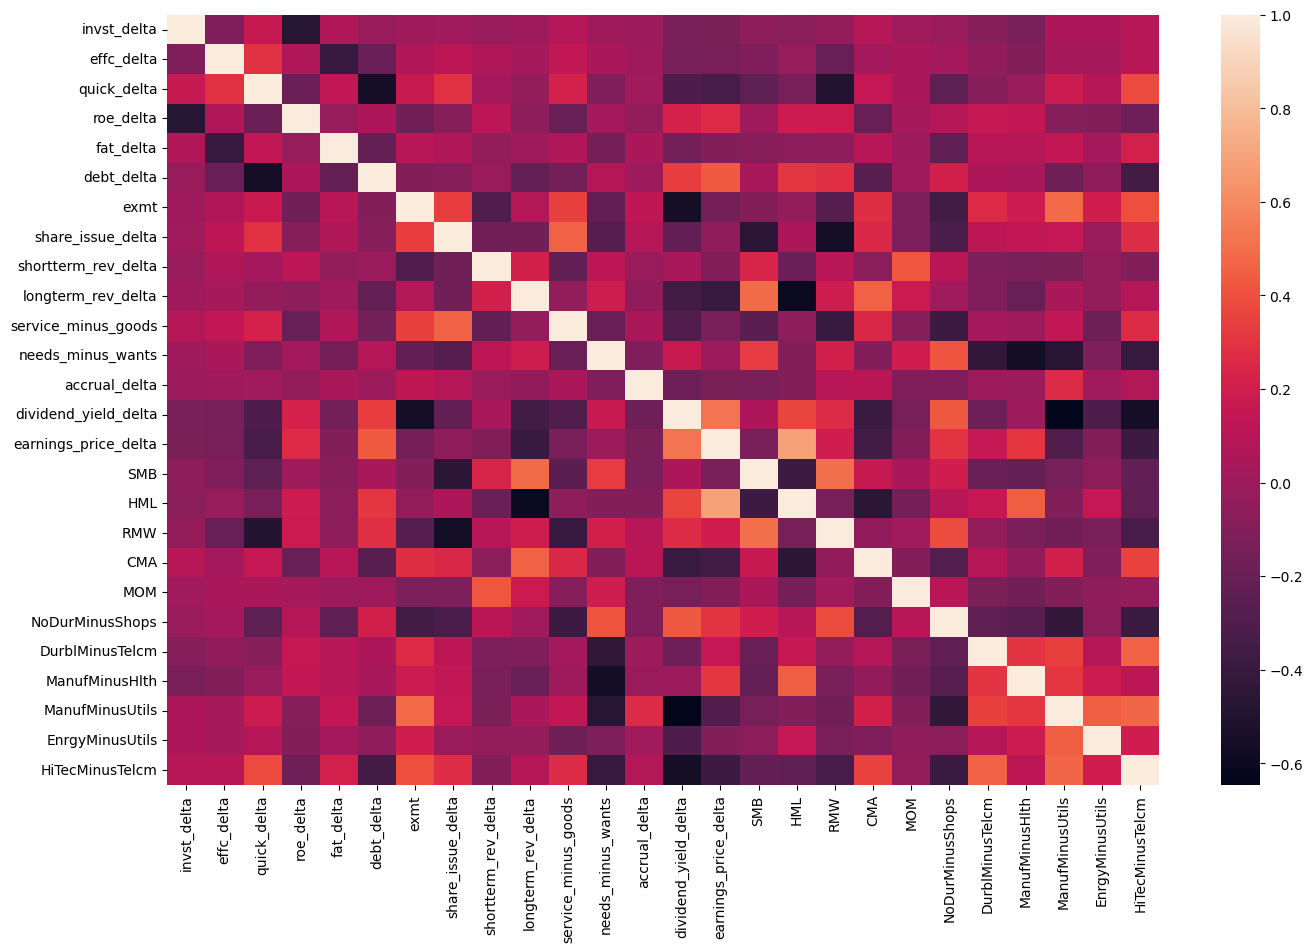

In [151]:
# Now that our dataset is complete, let's take a look at a correlation matrix:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(subset_df.corr(), annot = False)
plt.show()

##### Everything looks really good. We have good VIF for our entire dataset, and our correlation matrix seems to not have anything multicollinear

## **SECTION 3:** Ordinary Least Squares

This section is <i>incomplete</i>

In [152]:
# Before regressing, let's just make some relevant lists based on how we constructed the dataframes:
fama_factors = ['SMB', 'HML', 'RMW', 'CMA', 'MOM']
alt_factors = ['share_issue_delta', 'shortterm_rev_delta', 'longterm_rev_delta', 'accrual_delta', 'dividend_yield_delta', 'earnings_price_delta']
built_factors = ['invst_delta', 'effc_delta', 'quick_delta', 'roe_delta', 'fat_delta', 'debt_delta']
hand_picked_industry_factors = ['service_minus_goods', 'needs_minus_wants']
post_lasso_industry_factors = ['NoDurMinusShops', 'DurblMinusTelcm', 'ManufMinusHlth', 'ManufMinusUtils', 'EnrgyMinusUtils', 'HiTecMinusTelcm']
default_factors = ['const', 'exmt']

In [153]:
# We must filter out all dates not included in our exogenous data:
ew_mom = port[port['caldt'].isin(subset_df['caldt'])].reset_index(drop=True)
sp_df = sp_df[sp_df['caldt'].isin(subset_df['caldt'])].reset_index(drop=True)

# And we must add a constant to our dataframe:
subset_df = add_constant(subset_df)
subset_df = subset_df.reset_index(drop=True)
subset_df.head()

,const,caldt,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta,exmt,share_issue_delta,...,HML,RMW,CMA,MOM,NoDurMinusShops,DurblMinusTelcm,ManufMinusHlth,ManufMinusUtils,EnrgyMinusUtils,HiTecMinusTelcm
0,1.0,1971-03-31,4.258862,8.725993,-4.267505,-4.258862,-9.740229,2.564440,4.13,2.78,...,-3.55,-0.01,2.77,-2.80,-2.41,2.75,0.40,1.69,0.32,7.35
1,1.0,1971-06-30,14.115646,-3.121529,2.962219,-11.471536,-1.248432,-4.114539,-0.10,-0.46,...,-1.89,0.61,2.71,5.61,-0.50,-1.59,-1.67,-3.91,-3.25,-3.22
2,1.0,1971-09-30,8.090797,-5.437865,0.155323,-8.090797,4.440234,0.809189,-0.85,-0.63,...,-4.72,4.25,1.20,4.17,-0.82,-0.32,-0.98,1.17,-0.18,-1.83
3,1.0,1971-12-31,2.091605,-0.578033,0.522921,-1.088670,0.499728,1.144433,8.71,2.42,...,1.15,-2.25,5.43,-0.98,0.28,-1.35,2.08,1.75,0.71,3.74
4,1.0,1972-06-30,0.458839,-1.515874,-1.565286,-0.458839,-0.336147,1.997659,-2.43,-1.89,...,-6.71,4.83,0.39,6.44,2.93,-0.28,-4.80,-0.70,0.58,0.09


In [154]:
OLS(exog = subset_df[default_factors + fama_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
     endog = sp_df['ret']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.4493
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.992
Time:                        19:04:45   Log-Likelihood:                -1038.7
No. Observations:                 352   AIC:                             2131.
Df Residuals:                     325   BIC:                             2236.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7148      0.289      2.477      0.014       0.147       1.283
exmt                    -0.0069      0.079     -0.087      0.930      -0.161       0.148
SMB                     -0.0576      0.077     -0.747      0.455      -0.209       0.094
HML                      0.0786      0.106      0.741      0.459      -0.130       0.287
RMW                      0.0814      0.096      0.847      0.397      -0.108       0.270
CMA                      0.0616      0.104      0.593      0.554      -0.143       0.266
MOM                     -0.0091      0.046     -0.199      0.843      -0.099       0.081
share_issue_delta       -0.0713      0.115     -0.623      0.534      -0.297       0.154
shortterm_rev_delta      0.0862      0.056      1.536      0.126      -0.024       0.197
longterm_rev_delta       0.0358      0.071      0.503      0.615      -0.104       0.176
accrual_delta           -0.0661      0.103     -0.642      0.522      -0.269       0.136
dividend_yield_delta     0.0333      0.094      0.353      0.724      -0.152       0.219
earnings_price_delta    -0.0245      0.098     -0.251      0.802      -0.217       0.168
invst_delta             -0.0009      0.024     -0.039      0.969      -0.048       0.046
effc_delta               0.0251      0.043      0.585      0.559      -0.059       0.110
quick_delta             -0.0204      0.041     -0.497      0.619      -0.101       0.060
roe_delta               -0.0152      0.021     -0.717      0.474      -0.057       0.026
fat_delta               -0.0213      0.044     -0.480      0.631      -0.109       0.066
debt_delta              -0.0241      0.045     -0.541      0.589      -0.112       0.064
service_minus_goods      0.0008      0.018      0.047      0.963      -0.034       0.036
needs_minus_wants       -0.0182      0.022     -0.826      0.409      -0.062       0.025
NoDurMinusShops         -0.1451      0.114     -1.278      0.202      -0.368       0.078
DurblMinusTelcm         -0.0629      0.064     -0.982      0.327      -0.189       0.063
ManufMinusHlth          -0.0910      0.098     -0.926      0.355      -0.284       0.102
ManufMinusUtils         -0.0019      0.102     -0.019      0.985      -0.202       0.198
EnrgyMinusUtils          0.0545      0.062      0.883      0.378      -0.067       0.176
HiTecMinusTelcm          0.0164      0.076      0.214      0.830      -0.134       0.167
==============================================================================
Omnibus:                       32.568   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.659
Skew:                          -0.483   Prob(JB):                     2.75e-16
Kurtosis:                       4.988   Cond. No.                         25.3
==================

In [155]:
OLS(exog = subset_df[default_factors + fama_factors],
     endog = sp_df['ret']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.1952
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.978
Time:                        19:04:45   Log-Likelihood:                -1044.3
No. Observations:                 352   AIC:                             2103.
Df Residuals:                     345   BIC:                             2130.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7951      0.268      2.965      0.003       0.268       1.323
exmt          -0.0425      0.060     -0.710      0.478      -0.160       0.075
SMB           -0.0031      0.062     -0.051      0.960      -0.125       0.119
HML           -0.0150      0.066     -0.228      0.820      -0.144       0.114
RMW            0.0085      0.069      0.123      0.902      -0.128       0.145
CMA            0.0474      0.087      0.542      0.588      -0.124       0.219
MOM            0.0122      0.038      0.316      0.752      -0.064       0.088
==============================================================================
Omnibus:                       28.739   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.528
Skew:                          -0.415   Prob(JB):                     9.73e-15
Kurtosis:                       4.926   Cond. No.                         7.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
OLS(exog = subset_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
     endog = sp_df['ret']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.4757
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.977
Time:                        19:04:45   Log-Likelihood:                -1039.7
No. Observations:                 352   AIC:                             2123.
Df Residuals:                     330   BIC:                             2208.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7398      0.270      2.736      0.007       0.208       1.272
exmt                    -0.0153      0.077     -0.199      0.842      -0.166       0.136
share_issue_delta       -0.0708      0.097     -0.728      0.467      -0.262       0.120
shortterm_rev_delta      0.0678      0.051      1.339      0.181      -0.032       0.167
longterm_rev_delta       0.0223      0.058      0.382      0.703      -0.093       0.137
accrual_delta           -0.0303      0.096     -0.315      0.753      -0.220       0.159
dividend_yield_delta     0.0342      0.090      0.380      0.704      -0.143       0.211
earnings_price_delta     0.0196      0.085      0.230      0.818      -0.148       0.187
invst_delta              0.0041      0.023      0.178      0.859      -0.042       0.050
effc_delta               0.0305      0.042      0.720      0.472      -0.053       0.114
quick_delta             -0.0264      0.040     -0.662      0.509      -0.105       0.052
roe_delta               -0.0131      0.021     -0.635      0.526      -0.054       0.028
fat_delta               -0.0168      0.044     -0.381      0.703      -0.103       0.070
debt_delta              -0.0222      0.044     -0.509      0.611      -0.108       0.064
service_minus_goods      0.0007      0.017      0.042      0.966      -0.034       0.035
needs_minus_wants       -0.0183      0.021     -0.858      0.391      -0.060       0.024
NoDurMinusShops         -0.1364      0.110     -1.243      0.215      -0.352       0.080
DurblMinusTelcm         -0.0527      0.063     -0.834      0.405      -0.177       0.072
ManufMinusHlth          -0.0688      0.091     -0.757      0.450      -0.248       0.110
ManufMinusUtils         -0.0019      0.101     -0.019      0.985      -0.200       0.196
EnrgyMinusUtils          0.0567      0.058      0.979      0.328      -0.057       0.170
HiTecMinusTelcm          0.0174      0.074      0.235      0.815      -0.129       0.163
==============================================================================
Omnibus:                       32.627   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.750
Skew:                          -0.475   Prob(JB):                     9.67e-17
Kurtosis:                       5.031   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

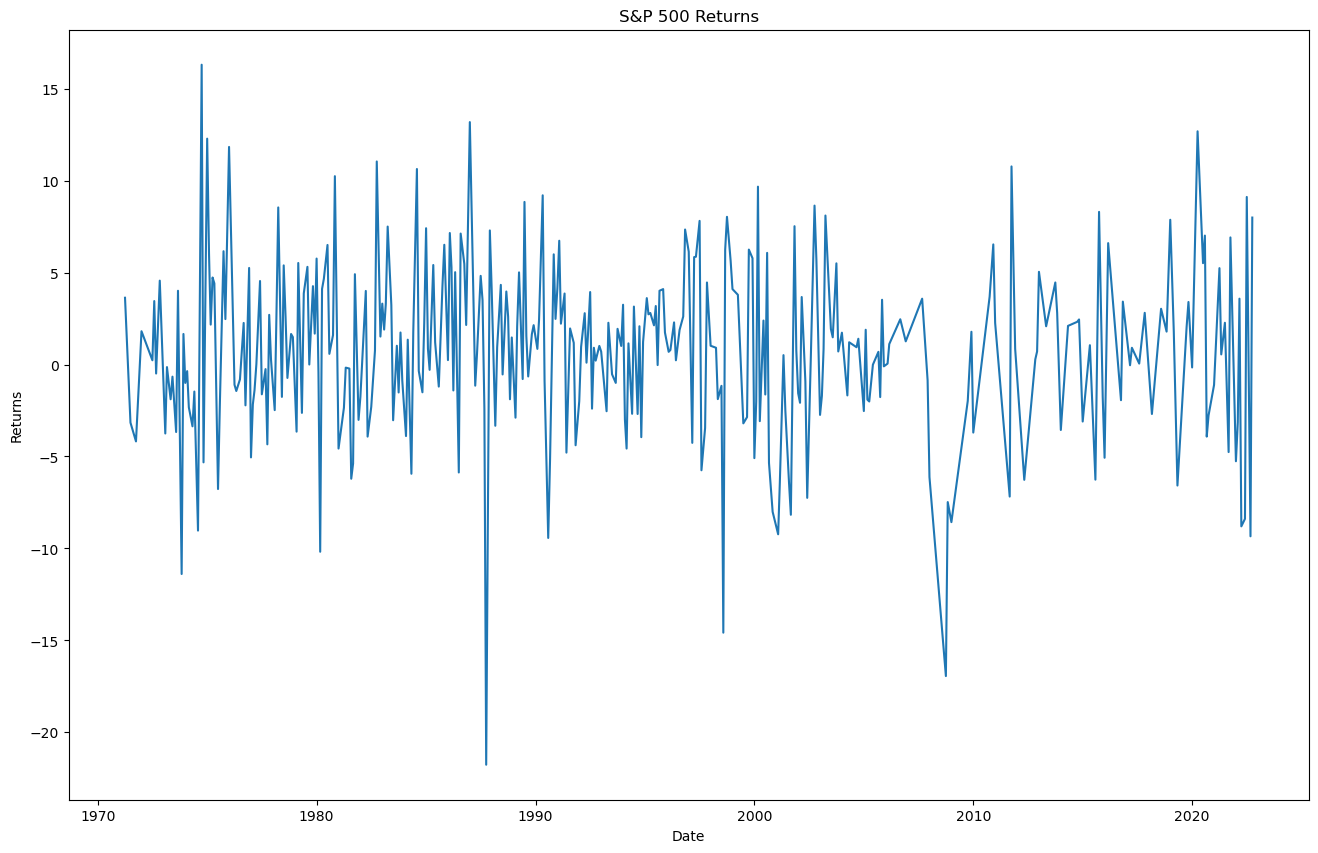

In [157]:
# plot sp_df['ret']
plt.rcParams["figure.figsize"] = (16, 10)
plt.plot(sp_df['caldt'], sp_df['ret'])
plt.title('S&P 500 Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

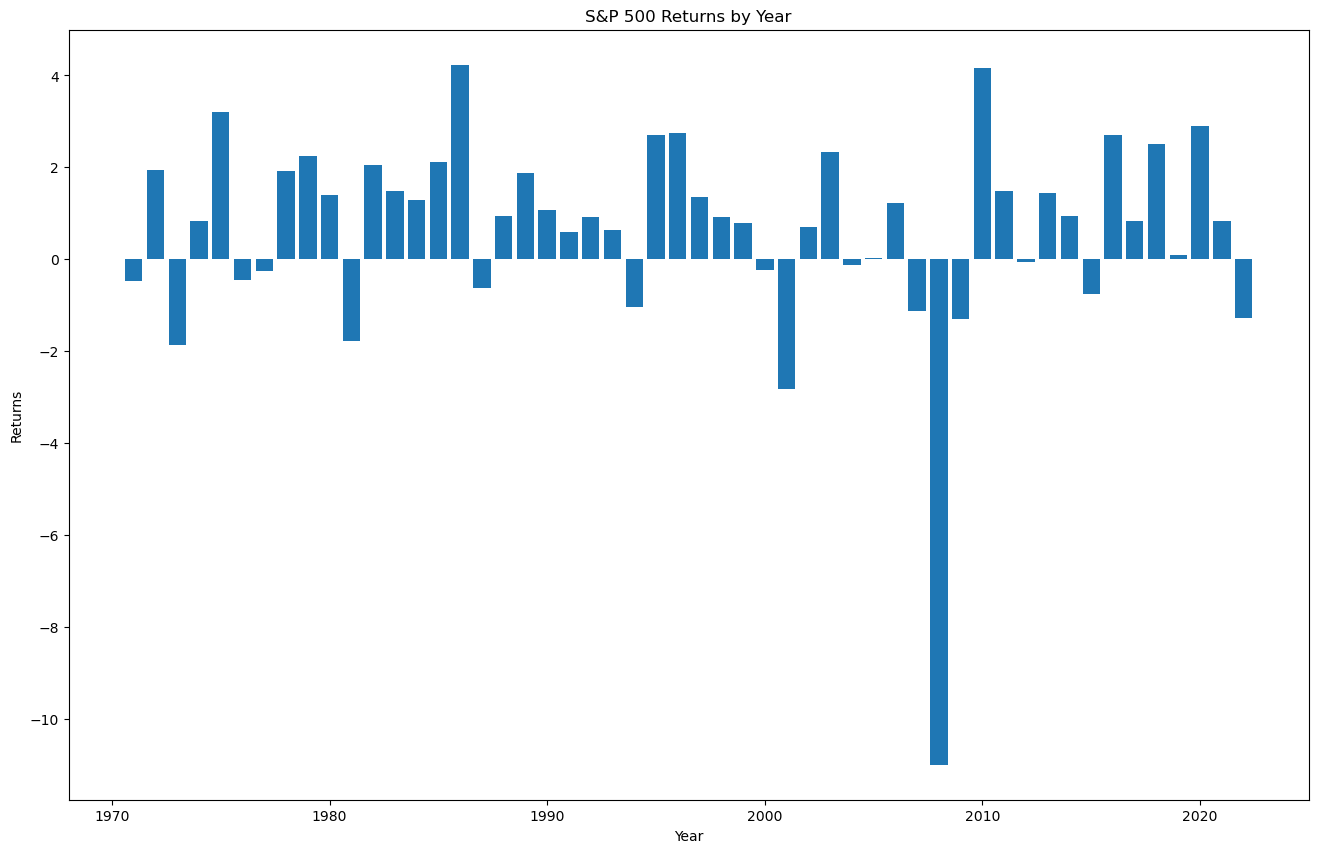

In [158]:
# plot sp_df['ret'] by yearly return, bar chart
plt.rcParams["figure.figsize"] = (16, 10)
plt.bar(sp_df.groupby(sp_df['caldt'].dt.year)['ret'].mean().index, sp_df.groupby(sp_df['caldt'].dt.year)['ret'].mean())
plt.title('S&P 500 Returns by Year')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()

In [159]:
# We can't explain the returns in 1970 well, but we might be able to explain more modern returns.
# Let's restrict our time period to 1995-Present:
# Motivation: Internet made it to the public in 1993. 1995 mod 5 is in the equivalence class of 0.

restricted_df = subset_df[subset_df['caldt'].dt.year >= 1990].reset_index(drop = True)
restricted_sp_df = sp_df[sp_df['caldt'].dt.year >= 1990].reset_index(drop = True)
restricted_ew_mom = ew_mom[ew_mom['caldt'].dt.year >= 1990].reset_index(drop = True)

In [160]:
# Since we restricted the dataset, we should recompute the VIF
vif_df = restricted_df.drop('caldt', axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i)
                            for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,const,1.395822
1,invst_delta,1.811082
2,effc_delta,1.782690
3,quick_delta,2.780563
4,roe_delta,2.000729
5,fat_delta,1.484707
6,debt_delta,2.497714
7,exmt,2.083844
8,share_issue_delta,2.561737
9,shortterm_rev_delta,1.530629


In [161]:
OLS(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
     endog = restricted_sp_df['ret']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.8084
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.707
Time:                        19:04:46   Log-Likelihood:                -580.51
No. Observations:                 200   AIC:                             1205.
Df Residuals:                     178   BIC:                             1278.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5314      0.370      1.436      0.153      -0.199       1.262
exmt                    -0.1440      0.102     -1.406      0.162      -0.346       0.058
share_issue_delta        0.0363      0.130      0.278      0.781      -0.221       0.294
shortterm_rev_delta      0.0092      0.059      0.156      0.876      -0.107       0.125
longterm_rev_delta      -0.0848      0.071     -1.192      0.235      -0.225       0.056
accrual_delta           -0.1439      0.125     -1.151      0.251      -0.390       0.103
dividend_yield_delta    -0.0389      0.113     -0.345      0.730      -0.261       0.184
earnings_price_delta    -0.1395      0.112     -1.241      0.216      -0.361       0.082
invst_delta              0.0126      0.029      0.434      0.665      -0.045       0.070
effc_delta              -0.0184      0.053     -0.350      0.727      -0.122       0.085
quick_delta             -0.0638      0.050     -1.269      0.206      -0.163       0.035
roe_delta               -0.0040      0.025     -0.162      0.872      -0.053       0.045
fat_delta               -0.0113      0.056     -0.201      0.841      -0.122       0.100
debt_delta              -0.0802      0.058     -1.384      0.168      -0.195       0.034
service_minus_goods      0.0131      0.024      0.540      0.590      -0.035       0.061
needs_minus_wants       -0.0063      0.030     -0.210      0.834      -0.065       0.053
NoDurMinusShops          0.2988      0.140      2.138      0.034       0.023       0.575
DurblMinusTelcm          0.0134      0.069      0.195      0.846      -0.123       0.150
ManufMinusHlth           0.0446      0.118      0.377      0.707      -0.189       0.278
ManufMinusUtils          0.1242      0.124      0.998      0.320      -0.121       0.370
EnrgyMinusUtils         -0.1022      0.072     -1.411      0.160      -0.245       0.041
HiTecMinusTelcm         -0.0625      0.091     -0.687      0.493      -0.242       0.117
==============================================================================
Omnibus:                        2.152   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                1.960
Skew:                          -0.242   Prob(JB):                        0.375
Kurtosis:                       3.035   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
OLS(exog = restricted_df[default_factors + fama_factors],
     endog = restricted_sp_df['ret']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.423
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.208
Time:                        19:04:46   Log-Likelihood:                -585.29
No. Observations:                 200   AIC:                             1185.
Df Residuals:                     193   BIC:                             1208.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7395      0.347      2.131      0.034       0.055       1.424
exmt          -0.1786      0.083     -2.151      0.033      -0.342      -0.015
SMB           -0.0854      0.080     -1.063      0.289      -0.244       0.073
HML            0.0012      0.084      0.015      0.988      -0.165       0.168
RMW            0.0328      0.084      0.391      0.696      -0.132       0.198
CMA            0.0938      0.097      0.969      0.334      -0.097       0.285
MOM           -0.0632      0.046     -1.382      0.168      -0.153       0.027
==============================================================================
Omnibus:                        8.365   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.285
Skew:                          -0.437   Prob(JB):                       0.0159
Kurtosis:                       3.481   Cond. No.                         8.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
OLS(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
     endog = restricted_ew_mom['p3']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     p3   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     60.91
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           8.03e-70
Time:                        19:04:46   Log-Likelihood:                -369.76
No. Observations:                 200   AIC:                             783.5
Df Residuals:                     178   BIC:                             856.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7175      0.129      5.562      0.000       0.463       0.972
exmt                     0.7772      0.036     21.763      0.000       0.707       0.848
share_issue_delta        0.1483      0.045      3.261      0.001       0.059       0.238
shortterm_rev_delta     -0.0740      0.020     -3.616      0.000      -0.114      -0.034
longterm_rev_delta      -0.1390      0.025     -5.605      0.000      -0.188      -0.090
accrual_delta           -0.0012      0.044     -0.027      0.979      -0.087       0.085
dividend_yield_delta     0.0164      0.039      0.417      0.677      -0.061       0.094
earnings_price_delta     0.0906      0.039      2.310      0.022       0.013       0.168
invst_delta              0.0252      0.010      2.489      0.014       0.005       0.045
effc_delta               0.0115      0.018      0.626      0.532      -0.025       0.048
quick_delta              0.0151      0.018      0.860      0.391      -0.020       0.050
roe_delta                0.0164      0.009      1.903      0.059      -0.001       0.033
fat_delta                0.0226      0.020      1.152      0.251      -0.016       0.061
debt_delta              -0.0007      0.020     -0.035      0.972      -0.041       0.039
service_minus_goods      0.0004      0.008      0.047      0.963      -0.016       0.017
needs_minus_wants        0.0323      0.010      3.105      0.002       0.012       0.053
NoDurMinusShops         -0.0396      0.049     -0.813      0.417      -0.136       0.057
DurblMinusTelcm          0.0551      0.024      2.289      0.023       0.008       0.103
ManufMinusHlth           0.0697      0.041      1.687      0.093      -0.012       0.151
ManufMinusUtils          0.0565      0.043      1.301      0.195      -0.029       0.142
EnrgyMinusUtils         -0.0134      0.025     -0.531      0.596      -0.063       0.036
HiTecMinusTelcm         -0.0316      0.032     -0.996      0.321      -0.094       0.031
==============================================================================
Omnibus:                        0.484   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.785   Jarque-Bera (JB):                0.226
Skew:                           0.032   Prob(JB):                        0.893
Kurtosis:                       3.152   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
OLS(exog = restricted_df[default_factors + fama_factors],
     endog = restricted_ew_mom['p3']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     p3   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     432.1
Date:                Fri, 14 Apr 2023   Prob (F-statistic):          5.49e-109
Time:                        19:04:46   Log-Likelihood:                -313.04
No. Observations:                 200   AIC:                             640.1
Df Residuals:                     193   BIC:                             663.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4861      0.089      5.466      0.000       0.311       0.662
exmt           0.8620      0.021     40.508      0.000       0.820       0.904
SMB           -0.2868      0.021    -13.917      0.000      -0.327      -0.246
HML            0.1660      0.022      7.676      0.000       0.123       0.209
RMW            0.0762      0.021      3.553      0.000       0.034       0.119
CMA            0.0467      0.025      1.884      0.061      -0.002       0.096
MOM            0.0475      0.012      4.059      0.000       0.024       0.071
==============================================================================
Omnibus:                        2.482   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.090
Skew:                           0.192   Prob(JB):                        0.352
Kurtosis:                       3.321   Cond. No.                         8.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **SECTION 4:** Alternative Estimation

In [167]:
# In this section we perform quantile regression over the restricted dataset.
# FIFTIETH PERCENTILE
QuantReg(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
         endog = restricted_ew_mom['spread']).fit(q = 0.5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 spread   Pseudo R-squared:               0.1078
Model:                       QuantReg   Bandwidth:                       2.974
Method:                 Least Squares   Sparsity:                        9.887
Date:                Fri, 14 Apr 2023   No. Observations:                  200
Time:                        19:05:18   Df Residuals:                      178
                                        Df Model:                           21
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8946      0.384      2.329      0.021       0.136       1.653
exmt                    -0.0728      0.106     -0.686      0.494      -0.282       0.137
share_issue_delta       -0.2654      0.130     -2.046      0.042      -0.521      -0.009
shortterm_rev_delta      0.2539      0.063      4.038      0.000       0.130       0.378
longterm_rev_delta      -0.2188      0.074     -2.956      0.004      -0.365      -0.073
accrual_delta           -0.0100      0.132     -0.076      0.940      -0.270       0.250
dividend_yield_delta    -0.3055      0.116     -2.626      0.009      -0.535      -0.076
earnings_price_delta    -0.2060      0.118     -1.747      0.082      -0.439       0.027
invst_delta              0.0116      0.029      0.399      0.690      -0.046       0.069
effc_delta               0.0443      0.054      0.821      0.413      -0.062       0.151
quick_delta              0.0683      0.050      1.375      0.171      -0.030       0.166
roe_delta                0.0132      0.024      0.550      0.583      -0.034       0.061
fat_delta                0.0090      0.055      0.164      0.870      -0.100       0.118
debt_delta               0.1242      0.060      2.076      0.039       0.006       0.242
service_minus_goods     -0.0129      0.024     -0.541      0.589      -0.060       0.034
needs_minus_wants       -0.0059      0.032     -0.181      0.856      -0.070       0.058
NoDurMinusShops          0.0308      0.145      0.213      0.832      -0.255       0.316
DurblMinusTelcm         -0.0979      0.069     -1.413      0.159      -0.235       0.039
ManufMinusHlth           0.0225      0.125      0.180      0.857      -0.224       0.269
ManufMinusUtils         -0.1641      0.130     -1.263      0.208      -0.420       0.092
EnrgyMinusUtils          0.0615      0.074      0.827      0.409      -0.085       0.208
HiTecMinusTelcm         -0.0538      0.097     -0.557      0.578      -0.245       0.137
========================================================================================
"""

In [169]:
# .4 QUANTILE
QuantReg(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
         endog = restricted_ew_mom['spread']).fit(q = 0.4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 spread   Pseudo R-squared:               0.1078
Model:                       QuantReg   Bandwidth:                       2.974
Method:                 Least Squares   Sparsity:                        9.887
Date:                Fri, 14 Apr 2023   No. Observations:                  200
Time:                        19:06:17   Df Residuals:                      178
                                        Df Model:                           21
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8946      0.384      2.329      0.021       0.136       1.653
exmt                    -0.0728      0.106     -0.686      0.494      -0.282       0.137
share_issue_delta       -0.2654      0.130     -2.046      0.042      -0.521      -0.009
shortterm_rev_delta      0.2539      0.063      4.038      0.000       0.130       0.378
longterm_rev_delta      -0.2188      0.074     -2.956      0.004      -0.365      -0.073
accrual_delta           -0.0100      0.132     -0.076      0.940      -0.270       0.250
dividend_yield_delta    -0.3055      0.116     -2.626      0.009      -0.535      -0.076
earnings_price_delta    -0.2060      0.118     -1.747      0.082      -0.439       0.027
invst_delta              0.0116      0.029      0.399      0.690      -0.046       0.069
effc_delta               0.0443      0.054      0.821      0.413      -0.062       0.151
quick_delta              0.0683      0.050      1.375      0.171      -0.030       0.166
roe_delta                0.0132      0.024      0.550      0.583      -0.034       0.061
fat_delta                0.0090      0.055      0.164      0.870      -0.100       0.118
debt_delta               0.1242      0.060      2.076      0.039       0.006       0.242
service_minus_goods     -0.0129      0.024     -0.541      0.589      -0.060       0.034
needs_minus_wants       -0.0059      0.032     -0.181      0.856      -0.070       0.058
NoDurMinusShops          0.0308      0.145      0.213      0.832      -0.255       0.316
DurblMinusTelcm         -0.0979      0.069     -1.413      0.159      -0.235       0.039
ManufMinusHlth           0.0225      0.125      0.180      0.857      -0.224       0.269
ManufMinusUtils         -0.1641      0.130     -1.263      0.208      -0.420       0.092
EnrgyMinusUtils          0.0615      0.074      0.827      0.409      -0.085       0.208
HiTecMinusTelcm         -0.0538      0.097     -0.557      0.578      -0.245       0.137
========================================================================================
"""

In [172]:
# .2 QUANTILE
QuantReg(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
         endog = restricted_ew_mom['spread']).fit(q = 0.2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 spread   Pseudo R-squared:               0.1764
Model:                       QuantReg   Bandwidth:                       3.539
Method:                 Least Squares   Sparsity:                        13.20
Date:                Fri, 14 Apr 2023   No. Observations:                  200
Time:                        19:06:36   Df Residuals:                      178
                                        Df Model:                           21
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4688      0.457     -3.214      0.002      -2.371      -0.567
exmt                    -0.1714      0.124     -1.386      0.168      -0.415       0.073
share_issue_delta        0.1859      0.145      1.283      0.201      -0.100       0.472
shortterm_rev_delta      0.2630      0.090      2.937      0.004       0.086       0.440
longterm_rev_delta      -0.1714      0.090     -1.914      0.057      -0.348       0.005
accrual_delta           -0.1981      0.177     -1.120      0.264      -0.547       0.151
dividend_yield_delta    -0.4152      0.148     -2.803      0.006      -0.708      -0.123
earnings_price_delta    -0.2364      0.151     -1.569      0.118      -0.534       0.061
invst_delta              0.0233      0.030      0.783      0.435      -0.035       0.082
effc_delta               0.0293      0.063      0.463      0.644      -0.096       0.154
quick_delta              0.0737      0.052      1.420      0.157      -0.029       0.176
roe_delta                0.0204      0.025      0.816      0.416      -0.029       0.070
fat_delta                0.0324      0.051      0.634      0.527      -0.069       0.133
debt_delta               0.1935      0.075      2.571      0.011       0.045       0.342
service_minus_goods     -0.0400      0.028     -1.431      0.154      -0.095       0.015
needs_minus_wants        0.0450      0.046      0.983      0.327      -0.045       0.135
NoDurMinusShops         -0.0051      0.185     -0.027      0.978      -0.370       0.360
DurblMinusTelcm         -0.0406      0.077     -0.530      0.597      -0.192       0.111
ManufMinusHlth           0.1948      0.158      1.233      0.219      -0.117       0.506
ManufMinusUtils         -0.2445      0.158     -1.551      0.123      -0.556       0.067
EnrgyMinusUtils         -0.1167      0.096     -1.218      0.225      -0.306       0.072
HiTecMinusTelcm         -0.0241      0.110     -0.220      0.826      -0.241       0.192
========================================================================================
"""

In [173]:
QuantReg(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
         endog = restricted_ew_mom['spread']).fit(q = 0.6).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 spread   Pseudo R-squared:               0.1140
Model:                       QuantReg   Bandwidth:                       2.662
Method:                 Least Squares   Sparsity:                        8.878
Date:                Fri, 14 Apr 2023   No. Observations:                  200
Time:                        19:07:05   Df Residuals:                      178
                                        Df Model:                           21
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9885      0.344      8.689      0.000       2.310       3.667
exmt                    -0.0349      0.097     -0.358      0.720      -0.227       0.157
share_issue_delta       -0.4183      0.124     -3.373      0.001      -0.663      -0.174
shortterm_rev_delta      0.1043      0.054      1.929      0.055      -0.002       0.211
longterm_rev_delta      -0.2383      0.068     -3.517      0.001      -0.372      -0.105
accrual_delta           -0.0203      0.120     -0.170      0.865      -0.256       0.216
dividend_yield_delta    -0.3404      0.107     -3.175      0.002      -0.552      -0.129
earnings_price_delta    -0.1791      0.105     -1.711      0.089      -0.386       0.027
invst_delta              0.0091      0.028      0.326      0.745      -0.046       0.064
effc_delta               0.0480      0.050      0.960      0.339      -0.051       0.147
quick_delta              0.0617      0.049      1.249      0.213      -0.036       0.159
roe_delta               -0.0001      0.024     -0.006      0.995      -0.048       0.047
fat_delta                0.0497      0.056      0.887      0.376      -0.061       0.160
debt_delta               0.0328      0.055      0.594      0.553      -0.076       0.142
service_minus_goods     -0.0388      0.023     -1.701      0.091      -0.084       0.006
needs_minus_wants        0.0231      0.026      0.887      0.376      -0.028       0.074
NoDurMinusShops          0.0878      0.133      0.660      0.510      -0.175       0.350
DurblMinusTelcm         -0.0686      0.061     -1.117      0.265      -0.190       0.053
ManufMinusHlth           0.1371      0.109      1.258      0.210      -0.078       0.352
ManufMinusUtils         -0.0125      0.116     -0.107      0.915      -0.242       0.217
EnrgyMinusUtils         -0.0809      0.065     -1.239      0.217      -0.210       0.048
HiTecMinusTelcm         -0.1096      0.084     -1.299      0.196      -0.276       0.057
========================================================================================
"""

In [174]:
QuantReg(exog = restricted_df[default_factors + alt_factors + built_factors + hand_picked_industry_factors + post_lasso_industry_factors],
         endog = restricted_ew_mom['spread']).fit(q = 0.8).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 spread   Pseudo R-squared:               0.1217
Model:                       QuantReg   Bandwidth:                       3.481
Method:                 Least Squares   Sparsity:                        13.98
Date:                Fri, 14 Apr 2023   No. Observations:                  200
Time:                        19:07:15   Df Residuals:                      178
                                        Df Model:                           21
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.3983      0.459     11.761      0.000       4.492       6.304
exmt                    -0.1764      0.137     -1.289      0.199      -0.447       0.094
share_issue_delta       -0.1711      0.165     -1.037      0.301      -0.497       0.154
shortterm_rev_delta      0.1007      0.081      1.244      0.215      -0.059       0.260
longterm_rev_delta      -0.2395      0.093     -2.564      0.011      -0.424      -0.055
accrual_delta            0.0009      0.169      0.005      0.996      -0.333       0.335
dividend_yield_delta    -0.2669      0.149     -1.794      0.074      -0.560       0.027
earnings_price_delta    -0.2112      0.141     -1.502      0.135      -0.489       0.066
invst_delta              0.0383      0.042      0.907      0.366      -0.045       0.122
effc_delta              -0.0090      0.077     -0.116      0.907      -0.161       0.143
quick_delta              0.0927      0.079      1.173      0.242      -0.063       0.249
roe_delta                0.0444      0.039      1.142      0.255      -0.032       0.121
fat_delta                0.0477      0.088      0.543      0.588      -0.126       0.221
debt_delta              -0.0549      0.077     -0.717      0.475      -0.206       0.096
service_minus_goods     -0.0022      0.030     -0.073      0.942      -0.062       0.058
needs_minus_wants       -0.0003      0.029     -0.011      0.991      -0.057       0.056
NoDurMinusShops          0.2422      0.184      1.317      0.189      -0.121       0.605
DurblMinusTelcm         -0.0275      0.083     -0.331      0.741      -0.192       0.137
ManufMinusHlth           0.0140      0.143      0.098      0.922      -0.268       0.296
ManufMinusUtils          0.0631      0.165      0.383      0.702      -0.262       0.388
EnrgyMinusUtils         -0.1031      0.089     -1.162      0.247      -0.278       0.072
HiTecMinusTelcm         -0.0984      0.119     -0.825      0.411      -0.334       0.137
========================================================================================
"""